Lindbald Master Equation and Hamiltonian

---

$$ \dot\rho=-i[H_{1},\rho]+\gamma_{1D}[2\sigma_{1}\rho\sigma_{1}^{\dagger}-\sigma_{1}^{\dagger}\sigma_{1}\rho-\rho\sigma_{1}^{\dagger}\sigma_{1}] $$

$$ H_{1}=[\omega_{0}+A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1}-\frac{i\Omega_{R}}{2}(e^{-i\varepsilon t}\sigma_{1}^{\dagger}-H.c) $$

Hamiltonian with Detuning



---
$$ U(t)=e^{i\epsilon t\sigma_{1}^{\dagger}\sigma_{1}} $$

$$ H_{1}^{'}=U^{\dagger}H_{1}U - iU^{\dagger}\frac{\partial U}{\partial t} $$

$$ iU^{\dagger}\frac{\partial U}{\partial t} = i(-i\epsilon)\sigma_{1}^{\dagger}\sigma_{1} = -\epsilon\sigma_{1}^{\dagger}\sigma_{1} $$

$$ U^{\dagger}(e^{-i\epsilon t}\sigma_{1}^{\dagger})U = e^{-i\epsilon t} \cdotp e^{i\epsilon t} \sigma_{1}^{\dagger} = \sigma_{1}^{\dagger}$$

$$ \delta = \omega_{0} - \epsilon $$

$$ H^{'}_{1}(t) = [\delta + A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1} - \frac{i\Omega_{R}}{2}(\sigma_{1}^{\dagger} - \sigma_{1}) $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm

%matplotlib inline

In [21]:
gamma_1D = 1.0   # Decay rate
D = 0.5          # Detuning d = (omega_0 - epsilon)
Omega = 5        # Modulation frequency
Omega_R = 0.05   # Rabi frequency
A = 0.025        # Modulation amplitude

In [24]:
def pauli_matrices():
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    # Lowering operator (sigma_-)
    sigma = np.array([[0, 1], [0, 0]], dtype=complex)

    # Raising operator (sigma_+)
    sigma_dag = np.array([[0, 0], [1, 0]], dtype=complex)

    # Number operator
    n = sigma_dag @ sigma

    # Identity
    I = np.eye(2, dtype=complex)

    return sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I

sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I = pauli_matrices()

def A_modulation(t):
    return A * np.cos(Omega * t)

def hamiltonian(t):
    A_t = A_modulation(t)
    return (D + A_t) * n - ((1j * Omega_R) / 2) * (sigma_dag - sigma)

def commutator(A, B):
    return (A @ B) - (B @ A)

def lindblad_term(rho, s):
    s_dag = s.conj().T
    return 2 * s @ rho @ s_dag - s_dag @ s @ rho - rho @ s_dag @ s

def lindblad_master_equation(t, rho_vec):
    rho = rho_vec.reshape((2, 2))
    H = hamiltonian(t)  # Hamiltonian at time (t)
    drho_dt = (-1j * commutator(H, rho)) + (gamma_1D * lindblad_term(rho, sigma))
    return drho_dt.flatten()

def calculate_P(s):
    term1 = (s + 2 * gamma_1D)
    term2_inner = (s + gamma_1D)**2 + (Omega - D)**2
    term3 = Omega_R**2 * (s + gamma_1D)

    P_s = (term1 * term2_inner) + term3
    return P_s

def calculate_B1(s, omega_R, gamma_1D, D, Omega):
    term_1 = -1j * (omega_R / 2) * np.exp(-1j * Omega * 0)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D - 1j * (Omega - D)
    P_s = calculate_P(s)

    result = term_1 * term_2 * term_3 / P_s
    return result

def calculate_B2(s, omega_R, gamma_1D, D, Omega):
    term_1 = 1j * (omega_R / 2) * np.exp(-1j * Omega * 0)
    term_2 = s + gamma_1D * 2
    term_3 = s + gamma_1D + 1j * (Omega - D)
    P_s = calculate_P(s)

    result = term_1 * term_2 * term_3 / P_s
    return result

def calculate_B3(s, gamma_1D, D, Omega):
    term_1 = -(s + gamma_1D * 2)
    term_2 = (s + gamma_1D)**2 + (Omega - D)**2
    P_s = calculate_P(s)

    result = term_1 * term_2 / P_s
    return result

In [26]:
psi0 = np.array([1, 0], dtype=complex)  # Initial ground state, outer product
rho0 = np.outer(psi0, psi0.conj())
rho0_vec = rho0.flatten()

t_final = 10 / gamma_1D
times = np.linspace(0, t_final, 1000)

print("[*] Starting integration.")
solution = solve_ivp(
    lindblad_master_equation,
    t_span=(0, t_final),
    y0=rho0_vec,
    t_eval=times,
    method='DOP853',  # RK45
)

print("[*] Integration complete!")

# Observables from density matrix
n_expect = np.zeros(len(solution.t))
sigma_dag_expect = np.zeros(len(solution.t), dtype=complex)
sigma_expect = np.zeros(len(solution.t), dtype=complex)

for i, t in enumerate(solution.t):
    rho = solution.y[:, i].reshape((2, 2))

    # Expectation values
    n_expect[i] = np.trace(rho @ n).real
    sigma_dag_expect[i] = np.trace(rho @ sigma_dag)
    sigma_expect[i] = np.trace(rho @ sigma)

omega_range = np.linspace(-10, 10, 1000)
s_values = 1j * omega_range

B1_values = np.array([calculate_B1(s, Omega_R, gamma_1D, D, Omega) for s in s_values])
B2_values = np.array([calculate_B2(s, Omega_R, gamma_1D, D, Omega) for s in s_values])
B3_values = np.array([calculate_B3(s, gamma_1D, D, Omega) for s in s_values])

[*] Starting integration.
[*] Integration complete!


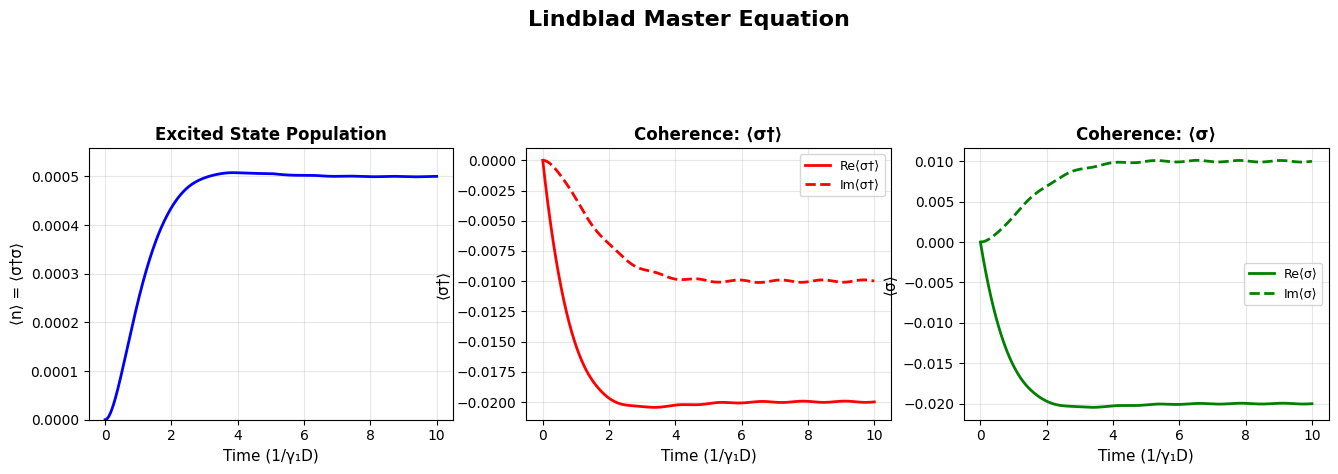

In [30]:
fig = plt.figure(figsize=(16, 12))

# Population in excited state
ax1 = plt.subplot(3, 3, 1)
ax1.plot(solution.t, n_expect, 'b-', linewidth=2)
ax1.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax1.set_ylabel('⟨n⟩ = ⟨σ†σ⟩', fontsize=11)
ax1.set_title('Excited State Population', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, max(n_expect) * 1.1])

# Sigma_Dag
ax2 = plt.subplot(3, 3, 2)
ax2.plot(solution.t, sigma_dag_expect.real, 'r-', linewidth=2, label='Re⟨σ†⟩')
ax2.plot(solution.t, sigma_dag_expect.imag, 'r--', linewidth=2, label='Im⟨σ†⟩')
ax2.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax2.set_ylabel('⟨σ†⟩', fontsize=11)
ax2.set_title('Coherence: ⟨σ†⟩', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# Sigma
ax3 = plt.subplot(3, 3, 3)
ax3.plot(solution.t, sigma_expect.real, 'g-', linewidth=2, label='Re⟨σ⟩')
ax3.plot(solution.t, sigma_expect.imag, 'g--', linewidth=2, label='Im⟨σ⟩')
ax3.set_xlabel('Time (1/γ₁D)', fontsize=11)
ax3.set_ylabel('⟨σ⟩', fontsize=11)
ax3.set_title('Coherence: ⟨σ⟩', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

plt.suptitle('Lindblad Master Equation',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

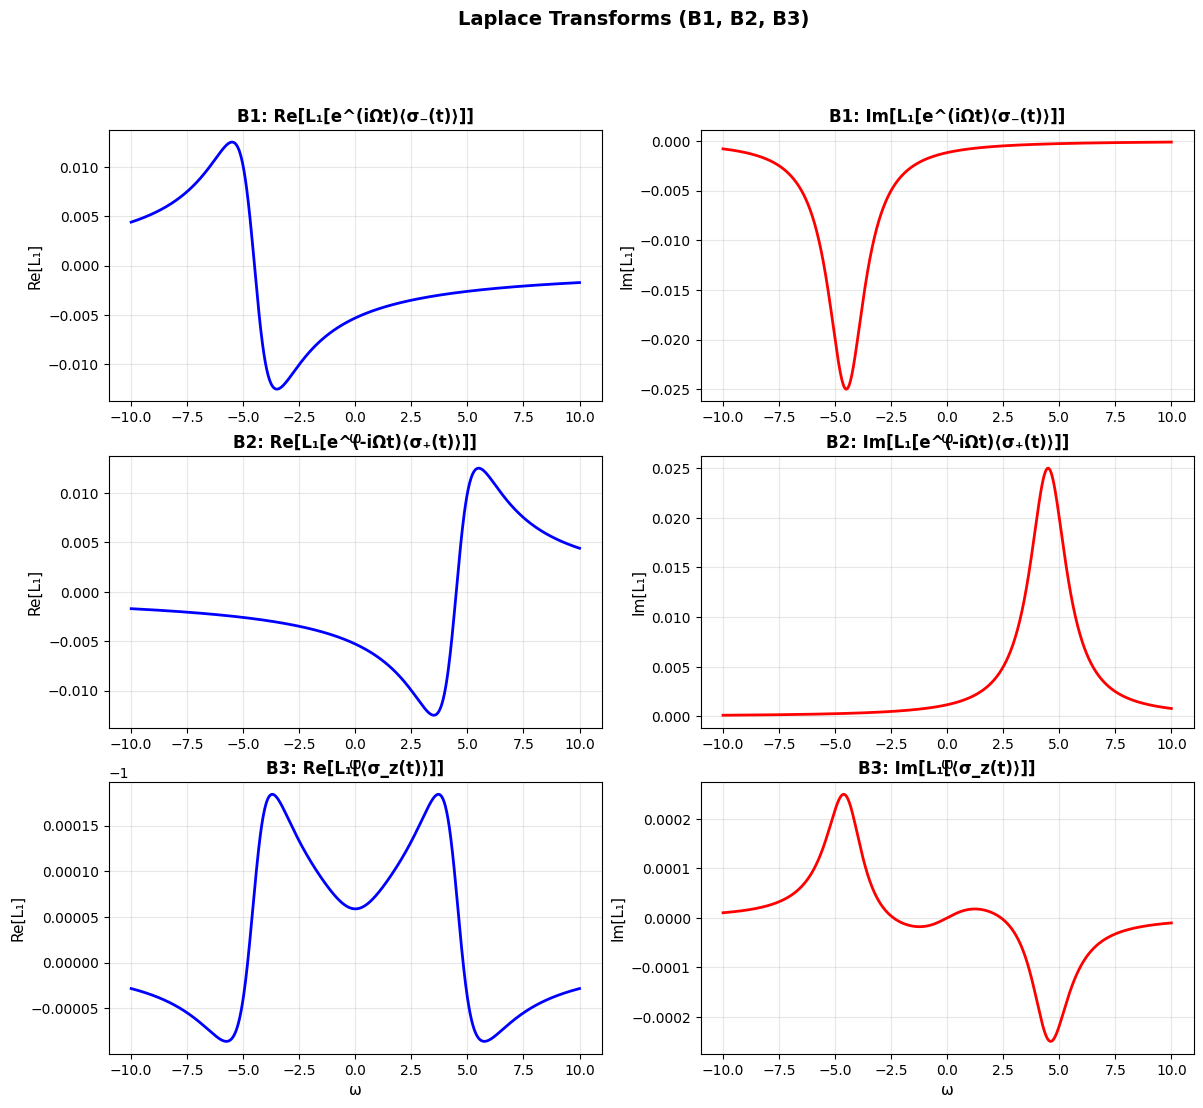

In [31]:
fig2, axes = plt.subplots(3, 2, figsize=(14, 12))

# B1
axes[0, 0].plot(omega_range, B1_values.real, 'b-', linewidth=2)
axes[0, 0].set_xlabel('ω', fontsize=11)
axes[0, 0].set_ylabel('Re[L₁]', fontsize=11)
axes[0, 0].set_title('B1: Re[L₁[e^(iΩt)⟨σ₋(t)⟩]]', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(omega_range, B1_values.imag, 'r-', linewidth=2)
axes[0, 1].set_xlabel('ω', fontsize=11)
axes[0, 1].set_ylabel('Im[L₁]', fontsize=11)
axes[0, 1].set_title('B1: Im[L₁[e^(iΩt)⟨σ₋(t)⟩]]', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# B2
axes[1, 0].plot(omega_range, B2_values.real, 'b-', linewidth=2)
axes[1, 0].set_xlabel('ω', fontsize=11)
axes[1, 0].set_ylabel('Re[L₁]', fontsize=11)
axes[1, 0].set_title('B2: Re[L₁[e^(-iΩt)⟨σ₊(t)⟩]]', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(omega_range, B2_values.imag, 'r-', linewidth=2)
axes[1, 1].set_xlabel('ω', fontsize=11)
axes[1, 1].set_ylabel('Im[L₁]', fontsize=11)
axes[1, 1].set_title('B2: Im[L₁[e^(-iΩt)⟨σ₊(t)⟩]]', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# B3
axes[2, 0].plot(omega_range, B3_values.real, 'b-', linewidth=2)
axes[2, 0].set_xlabel('ω', fontsize=11)
axes[2, 0].set_ylabel('Re[L₁]', fontsize=11)
axes[2, 0].set_title('B3: Re[L₁[⟨σ_z(t)⟩]]', fontsize=12, fontweight='bold')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(omega_range, B3_values.imag, 'r-', linewidth=2)
axes[2, 1].set_xlabel('ω', fontsize=11)
axes[2, 1].set_ylabel('Im[L₁]', fontsize=11)
axes[2, 1].set_title('B3: Im[L₁[⟨σ_z(t)⟩]]', fontsize=12, fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)

plt.suptitle('Laplace Transforms (B1, B2, B3)',
             fontsize=14, fontweight='bold')
plt.show()